In [1]:
import networkx as nx
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd

DATA_PATH = "data/"

# Create network
- Load dataframe with shelves
- Implode dataframe to make shelves into edgelist
- Calculate assortativity
    - Genre
    - Degrees
- Get largest sub network
- Create communities
    - Color according to genre

In [ ]:
# Create the network
def create_network(threshhold=0.2): 
    """
    Creates the network from the shelf edges. 
    If the edges have already been created, they are loaded. 
    Otherwise, they are created and stored. The edges are filtered by the threshhold. The network is returned.
    
    Args: 
        threshhold (int): The minimum number of times an edge must appear to be included in the network.
    
    Returns:
        G (networkx.Graph): The network of book edges.
    """
    # If the edges have already been created, load them
    try: 
        # Load the shelf edges
        edges = np.load(DATA_PATH + 'shelf_edges.npy', allow_pickle=True).item() # (takes about 10 minutes)
    except: 
        # Create the shelf edges and store them (this takes about 12 hours)
        shelves_df = pd.read_csv(DATA_PATH + 'shelves_df.csv')
        # Collapse into shelves
        imploded_df = shelves_df.groupby('user_id')['book_id'].apply(list).reset_index()

        # Count occurrences of each book
        book_counts = {}
        for i, shelf in tqdm(imploded_df.iterrows(), total=imploded_df.shape[0]):
            for book in shelf['book_id']:
                if book in book_counts:
                    book_counts[book] += 1
                else:
                    book_counts[book] = 1

        # Count appearances of pairs of books 
        edges = {}
        for i, shelf in tqdm(imploded_df.iterrows(), total=imploded_df.shape[0]):
            if len(shelf['book_id']) > 1:
                # Generate pairs of books 
                for i in range(len(shelf['book_id'])):
                    for j in range(i+1, len(shelf['book_id'])):
                        # Create edge
                        edge = frozenset([shelf['book_id'][i], shelf['book_id'][j]])
                        # Add edge to dictionary
                        if edge in edges:
                            edges[edge] += 1
                        else:
                            edges[edge] = 1

        # Weigh edges by the inverse of the root of the number of times each book appears 
        for edge in edges:
            edges[edge] = edges[edge] / (book_counts[list(edge)[0]] * book_counts[list(edge)[1]])**0.5
        
        # Store the edges
        np.save(DATA_PATH + 'shelf_edges.npy', edges)
    
    # Remove edges that are below the threshhold
    edges = {k: v for k, v in edges.items() if v >= threshhold}

    # Create the network 
    G = nx.Graph()
    G.add_edges_from(edges.keys())

    return G 
    

In [ ]:
# Load/Generate the network 
try:
    # Load the network
    G = nx.read_gpickle(DATA_PATH + "shelves_network.gpickle")
except: 
    # Make the network 
    G = create_network(2000)

    # Save the network
    nx.write_gpickle(G, DATA_PATH + "shelves_network.gpickle")


## Analysis 

In [4]:
# load data 
shelves_df = pd.read_csv(DATA_PATH + 'shelves_df.csv')

In [5]:

imploded_df = shelves_df.groupby('user_id')['book_id'].apply(list).reset_index()
#imploded_df

In [4]:
# Create dictionary edges and appearances 
edges = {}

# Go through shelves to get edges
for i, shelf in tqdm(imploded_df.iterrows(), total=imploded_df.shape[0]):
    if len(shelf['book_id']) > 1:
        # Generate pairs of books 
        for i in range(len(shelf['book_id'])):
            for j in range(i+1, len(shelf['book_id'])):
                # Create edge
                edge = frozenset([shelf['book_id'][i], shelf['book_id'][j]])
                # Add edge to dictionary
                if edge in edges:
                    edges[edge] += 1
                else:
                    edges[edge] = 1

len(edges)


100%|██████████| 818569/818569 [10:58:28<00:00, 20.72it/s]    


28704535

In [5]:
# Save the edges
np.save(DATA_PATH + 'shelf_edges.npy', edges)

In [40]:
# Load the shelf edges
edges = np.load(DATA_PATH + 'shelf_edges.npy', allow_pickle=True).item()

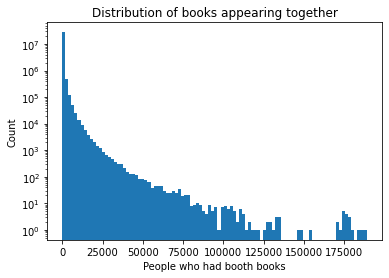

In [23]:
# Plot a histogram of the number of times each edge appears
plt.hist(edges.values(), log=True, bins=100)
# plt.xscale('log')
plt.xlabel('People who had booth books')
plt.ylabel('Count')
plt.title('Distribution of books appearing together')
plt.show()

In [13]:
sum(np.array(list(edges.values())) > 2000)

671121

In [14]:
# Remove all edges that appear less than threshhold times
threshhold = 2000
edges = {k: v for k, v in edges.items() if v >= threshhold}

In [17]:
G = nx.Graph()
G.add_edges_from(edges.keys())

In [19]:
print(G.number_of_edges(), G.number_of_nodes())

671643 5240


In [6]:
# Count occurrences of each book
book_counts = {}
for i, shelf in tqdm(imploded_df.iterrows(), total=imploded_df.shape[0]):
    for book in shelf['book_id']:
        if book in book_counts:
            book_counts[book] += 1
        else:
            book_counts[book] = 1

100%|██████████| 818569/818569 [00:43<00:00, 18861.56it/s]


Text(0.5, 1.0, 'Distribution of books appearing together')

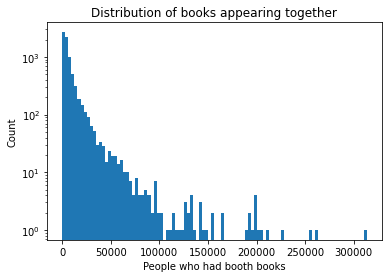

In [25]:
# Plot a histogram of the number of times each book appears
plt.hist(book_counts.values(), log=True, bins=100)
# plt.xscale('log')
plt.xlabel('People who had the book')
plt.ylabel('Count')
plt.title('Distribution of books appearing together')

In [28]:
edges.keys()

KeyboardInterrupt: 

In [31]:
for edge in tqdm(edges):
    edges[edge] = edges[edge] / (book_counts[list(edge)[0]] * book_counts[list(edge)[1]])**0.5



100%|██████████| 28704535/28704535 [00:34<00:00, 823585.16it/s]


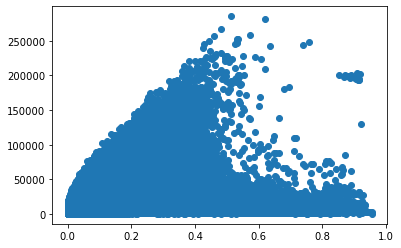

In [32]:

# Plot the edge versus the square root of the number of times each book appears
plt.scatter(edges.values(), [book_counts[list(edge)[0]]**0.5 * book_counts[list(edge)[1]]**0.5 for edge in edges.keys()])

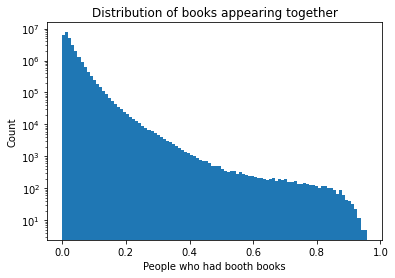

In [33]:
# Plot a histogram of the number of times each edge appears
plt.hist(edges.values(), log=True, bins=100)
# plt.xscale('log')
plt.xlabel('People who had booth books')
plt.ylabel('Count')
plt.title('Distribution of books appearing together')
plt.show()

In [37]:
# Remove all edges that appear less than threshhold times
threshhold = 0.2
edges = {k: v for k, v in edges.items() if v >= threshhold}

In [38]:
G = nx.Graph()
G.add_edges_from(edges.keys())

In [39]:
print(G.number_of_edges(), G.number_of_nodes())

42231 5083


### Decision

In [2]:
# Load the shelf edges
edges = np.load(DATA_PATH + 'shelf_edges.npy', allow_pickle=True).item()

In [7]:
# Normalize (kinda)
for edge in tqdm(edges):
    edges[edge] = edges[edge] / min(book_counts[list(edge)[0]], book_counts[list(edge)[1]])

100%|██████████| 28704535/28704535 [00:47<00:00, 601089.69it/s]


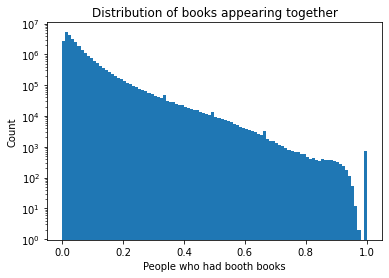

In [8]:
# Plot a histogram of the number of times each edge appears
plt.hist(edges.values(), log=True, bins=100)
# plt.xscale('log')
plt.xlabel('People who had booth books')
plt.ylabel('Count')
plt.title('Distribution of books appearing together')
plt.show()

In [13]:
# Remove all edges that appear less than threshhold times
threshhold = 0.3
edges2 = {k: v for k, v in edges.items() if v >= threshhold}

In [14]:
G = nx.Graph()
G.add_edges_from(edges2.keys())

In [15]:
print(G.number_of_edges(), G.number_of_nodes(), G.number_of_edges() / G.number_of_nodes())

591722 7674 77.10737555381809
